In [1]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

In [4]:
# Import Sionna components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, RadioMaterial, LambertianPattern
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, ApplyOFDMChannel
from sionna.nr import CarrierConfig, PUSCHDMRSConfig, TBConfig, PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import ebnodb2no, sim_ber

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

In [41]:
class CodedSystemAWGN(Model): # Inherits from Keras Model
    def __init__(self, num_bits_per_symbol, n, coderate):
        super().__init__() # Must call the Keras model initializer

        self.num_bits_per_symbol = num_bits_per_symbol
        self.n = n
        self.k = int(n*coderate)
        self.coderate = coderate
        self.constellation = sn.mapping.Constellation("qam", self.num_bits_per_symbol)

        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)

        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

        self.encoder = sn.fec.ldpc.LDPC5GEncoder(self.k, self.n)
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)

    #@tf.function # activate graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=self.coderate)

        bits = self.binary_source([batch_size, self.k])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y,no])
        bits_hat = self.decoder(llr)
        return bits, bits_hat

In [42]:
coderate = 0.5
batch_size = 120
ebno_db = np.linspace(-10, 20, num=61)
n_bits_per_symbol = [2,4,8]
BER = []
BLER = []

for NUM_BITS_PER_SYMBOL in n_bits_per_symbol:
    
    model_coded_awgn = CodedSystemAWGN(num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                   n=n,
                                   coderate=coderate)
    ber, bler = sim_ber(model_coded_awgn,
                        ebno_db,
                        batch_size=batch_size,
                        max_mc_iter=10,
                        num_target_block_errors=200)
    
    BER.append(list(ber.numpy()))
    BLER.append(list(bler.numpy()))

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 4.0112e-01 | 1.0000e+00 |       98580 |      245760 |          240 |         240 |         1.9 |reached target block errors
     -9.5 | 3.9383e-01 | 1.0000e+00 |       96787 |      245760 |          240 |         240 |         1.9 |reached target block errors
     -9.0 | 3.8940e-01 | 1.0000e+00 |       95700 |      245760 |          240 |         240 |         1.9 |reached target block errors
     -8.5 | 3.8099e-01 | 1.0000e+00 |       93631 |      245760 |          240 |         240 |         1.8 |reached target block errors
     -8.0 | 3.7544e-01 | 1.0000e+00 |       92267 |      245760 |          240 |         240 |         1.8 |reached target block errors
     -7.5 | 3.6682e-01 | 1.0000e+00 |       90150 |      245760 |

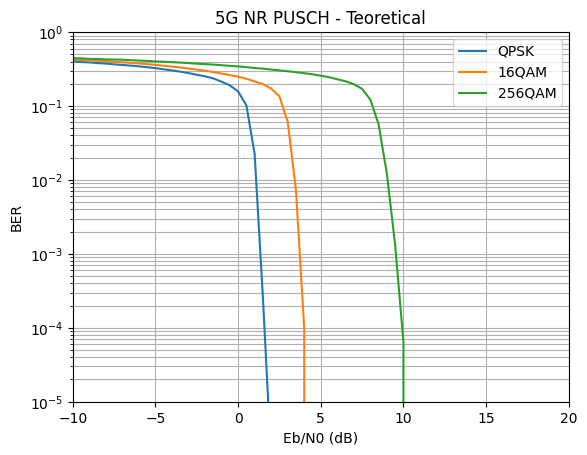

In [43]:
plt.figure()
plt.title("5G NR PUSCH - Teoretical")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.xlim([ebno_db[0], ebno_db[-1]])
plt.ylim([1e-5, 1.0])

i = 0
legend = []

for num_bits_per_symbol in n_bits_per_symbol:
    
    plt.semilogy(ebno_db, BER[i])
    i += 1
    if num_bits_per_symbol == 2:
        legend.append("QPSK")
    else:
        legend.append(str(2 ** num_bits_per_symbol) + "QAM")
    
plt.legend(legend);